## Import libraries and set dataset paths


In [9]:
from pathlib import Path

import datetime
from lib.dataloader import *

uav_set = Path("/home/emilia/WaterSegNet/datasets/uav_dataset/")
satelite_set = Path("/home/emilia/WaterSegNet/datasets/satelite_dataset/")
full_set = Path("/home/emilia/WaterSegNet/datasets/complete_dataset/")
# Directory paths for semantic segmentation dataset
root_dir = uav_set

dir_test_img = root_dir / "test/images"
dir_test_mask = root_dir / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

# Directory paths for checkpoints and best models
dir_checkpoint = root_dir / "checkpoints/"
dir_best_model = root_dir / "best_models/"
dir_best_model /= datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")


train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)

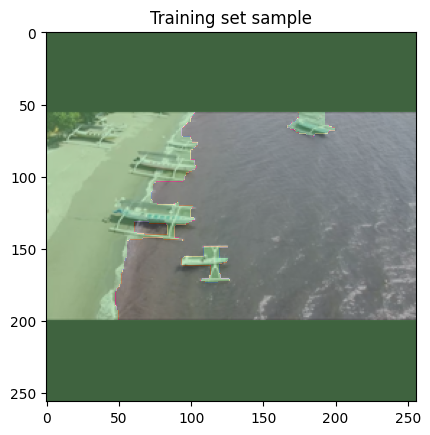

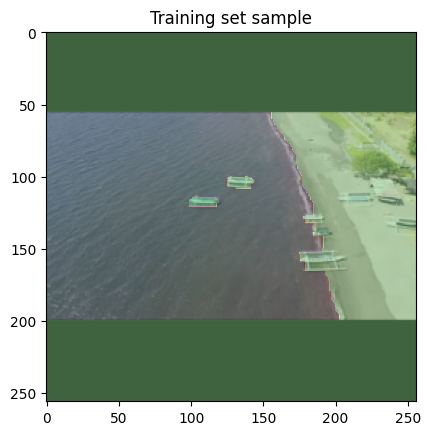

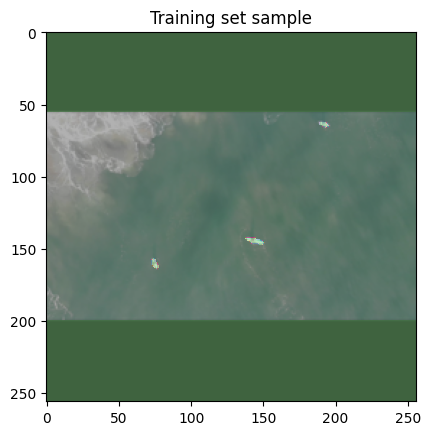

In [10]:
import matplotlib.pyplot as plt

for i in range(0, 3):
    sample = test_set[i]
    img, mask = sample["image"], sample["mask"]
    # for visualization we have to transpose back to HWC
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Training set sample")
    plt.show()

## Train


In [16]:
from lib.train import *
import segmentation_models_pytorch as smp
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

model = model.to(memory_format=torch.channels_last)

metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Recall(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Precision(task="binary", num_classes=1, multiclass=False),
    torchmetrics.F1Score(
        task="binary", num_classes=1, multiclass=False
    ),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)
test_metrics = torchmetrics.MetricTracker(metrics)


seg_model = SegModel(
    model,
    lr=1e-3,
    optimizer_type="adam",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    freeze_encoder=False,
)
data_module = SegDataModule(train_set, valid_set, test_set, batch_size=16)
model_name = "unet_resnet34_adam_b16"

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/checkpoints_padded/",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="model-{}".format(model_name),
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=True, mode="min"
)

tb_logger = TensorBoardLogger("lightning_logs/checkpoints_padded/", name=model_name)

trainer = Trainer(
    max_epochs=200,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback, early_stopping],
    logger=tb_logger,
    precision=16,  # Mixed precision training
)

trainer.fit(seg_model, data_module)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | Unet              | 24.4 M
1 | criterion            | BCEWithLogitsLoss | 0     
2 | dice_loss            | DiceLoss          | 0     
3 | train_metric_tracker | MetricTracker     | 0     
4 | val_metric_tracker   | MetricTracker     | 0     
5 | test_metric_tracker  | MetricTracker     | 0     
-----------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.873    Total estimated model params size (MB)
/home/emilia/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/emilia/WaterSegNet/checkpoi

Epoch 0: 100%|██████████| 84/84 [00:14<00:00,  5.81it/s, loss=0.293, v_num=0]

Metric val_loss improved. New best score: 0.293


Epoch 1: 100%|██████████| 84/84 [00:16<00:00,  5.22it/s, loss=0.242, v_num=0]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.237


Epoch 3: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s, loss=0.154, v_num=0]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.212


Epoch 4: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s, loss=0.119, v_num=0]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.147


Epoch 5: 100%|██████████| 84/84 [00:18<00:00,  4.65it/s, loss=0.0714, v_num=0]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.117


Epoch 6: 100%|██████████| 84/84 [00:17<00:00,  4.72it/s, loss=0.124, v_num=0] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.102


Epoch 7: 100%|██████████| 84/84 [00:16<00:00,  4.95it/s, loss=0.131, v_num=0] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.100


Epoch 12: 100%|██████████| 84/84 [00:17<00:00,  4.93it/s, loss=0.0369, v_num=0]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.077


Epoch 22: 100%|██████████| 84/84 [00:17<00:00,  4.88it/s, loss=0.0338, v_num=0]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.077. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 84/84 [00:17<00:00,  4.87it/s, loss=0.0338, v_num=0]


In [17]:
%load_ext tensorboard